In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from malid import io, config, helpers
from malid.datamodels import GeneLocus
from malid.datamodels import TargetObsColumnEnum
from malid.trained_model_wrappers.rollup_sequence_classifier import (
    RollupSequenceClassifier,
)
from malid.datamodels import GeneLocus
from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    SampleWeightStrategy,
)
import anndata
import genetools
from sklearn.metrics import classification_report
from malid.external.model_evaluation_scores import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
import scipy.stats
from slugify import slugify

pd.set_option("display.max_columns", 200)

In [2]:
# utility functions
def load_val_embeddings(fold_id: int, gene_locus: GeneLocus):
    return io.load_fold_embeddings(
        fold_id=fold_id,
        fold_label="validation",
        gene_locus=gene_locus,
        target_obs_column=TargetObsColumnEnum.disease,
    )


def build_classifier(fold_id: int, gene_locus: GeneLocus) -> RollupSequenceClassifier:
    return RollupSequenceClassifier(
        fold_id=fold_id,
        model_name_sequence_disease="lasso_multiclass",
        fold_label_train="train_smaller",  # what base models were trained on
        gene_locus=gene_locus,
        target_obs_column=TargetObsColumnEnum.disease,
        sample_weight_strategy=SampleWeightStrategy.ISOTYPE_USAGE,
    )


def evaluate(
    rollup_clf: RollupSequenceClassifier,
    proportiontocut: float,
    validation_embeddings: anndata.AnnData,
    strategy: str,  # e.g. "trimmed_mean"
    fold_id: int,
    gene_locus: GeneLocus,
) -> pd.Series:
    validation_preds = rollup_clf.predict_proba(
        validation_embeddings, proportiontocut=proportiontocut, strategy=strategy
    )
    classes = rollup_clf.classes_
    validation_preds["predicted"] = validation_preds[classes].idxmax(axis=1)
    validation_preds["true_label"] = (
        validation_embeddings.obs[["specimen_label", "disease"]]
        .drop_duplicates()
        .set_index("specimen_label")["disease"]
    )
    labels = validation_preds["true_label"].drop_duplicates().sort_values()
    report = precision_recall_fscore_support(
        validation_preds["true_label"], validation_preds["predicted"], labels=labels
    )
    report = pd.DataFrame(
        report, columns=labels, index=["precision", "recall", "fscore", "support"]
    )
    report = (
        report.loc[["precision", "recall"]].unstack().to_frame().sort_index(level=1).T
    )
    report.columns = ["_".join(col).strip() for col in report.columns.values]
    report = report.iloc[0]
    roc_auc = roc_auc_score(
        validation_preds["true_label"],
        validation_preds[classes],
        multi_class="ovo",
        average="weighted",
        labels=classes,
    )
    report["roc_auc"] = roc_auc
    report["proportiontocut"] = proportiontocut
    report["strategy"] = strategy
    report["fold_id"] = fold_id
    report["gene_locus"] = gene_locus.name

    print("*" * 80)
    print(f"gene_locus: {gene_locus}")
    print(f"proportiontocut: {proportiontocut}")
    print(f"strategy: {strategy}")
    print(f"fold_id: {fold_id}")
    print(f"roc_auc: {roc_auc}")
    print(
        classification_report(
            validation_preds["true_label"], validation_preds["predicted"]
        )
    )
    return report

# Visualize data from a single fold (fold 1, BCR)

In [3]:
validation_embeddings = load_val_embeddings(fold_id=1, gene_locus=GeneLocus.BCR)
validation_embeddings

2023-01-01 04:29:39,989 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.1.validation.h5ad -> /srv/scratch/maximz/cache/9c85c2a266a883a684e8c5d509b8321d4689380ae1339b1d3a20c9e8.1.validation.h5ad


Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


2023-01-01 04:30:29,777 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


AnnData object with n_obs × n_vars = 2980949 × 1900
    obs: 'v_gene', 'j_gene', 'disease', 'cdr1_seq_aa_q_trim', 'cdr2_seq_aa_q_trim', 'cdr3_seq_aa_q_trim', 'cdr3_aa_sequence_trim_len', 'extracted_isotype', 'isotype_supergroup', 'v_mut', 'num_reads', 'igh_or_tcrb_clone_id', 'total_clone_num_reads', 'num_clone_members', 'specimen_label', 'fold_id', 'fold_label', 'past_exposure', 'disease.separate_past_exposures', 'disease.rollup', 'sample_weight_isotype_rebalance', 'study_name', 'participant_label', 'specimen_time_point', 'disease_subtype', 'age', 'sex', 'ethnicity_condensed', 'age_group', 'age_group_binary', 'cmv', 'disease_severity', 'isotype_proportion:IGHG', 'isotype_proportion:IGHA', 'isotype_proportion:IGHD-M'
    uns: 'embedded', 'embedded_fine_tuned_on_fold_id', 'embedded_fine_tuned_on_gene_locus', 'original_uns_keys', 'original_obs_columns'
    obsm: 'X_pca'

In [4]:
rollup_clf = build_classifier(fold_id=1, gene_locus=GeneLocus.BCR)
rollup_clf

RollupSequenceClassifier(filter_to_high_confidence_subset=False, fold_id=1,
                         fold_label_train='train_smaller',
                         gene_locus=<GeneLocus.BCR: 1>,
                         model_name_sequence_disease='lasso_multiclass',
                         sample_weight_strategy=<SampleWeightStrategy.ISOTYPE_USAGE: 3>,
                         sequence_models_base_dir=PosixPath('/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_...ISOTYPE_USAGE'),
                         target_obs_column=<TargetObsColumnEnum.disease: TargetObsColumn(obs_column_name='disease', is_target_binary_for_repertoire_composition_classifier=False, limited_to_disease=None, require_metadata_columns_present=None, confusion_matrix_expanded_column_name='disease.separate_past_exposures', blended_evaluation_column_name='disease.rollup')>)

## How many sequences exist per sample?
We can see that the size distribution of sequences is skewed

2023-01-01 04:30:40,945 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2023-01-01 04:30:41,221 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(20.657916666666672, 0.5, 'count specimens')

<Figure size 432x288 with 0 Axes>

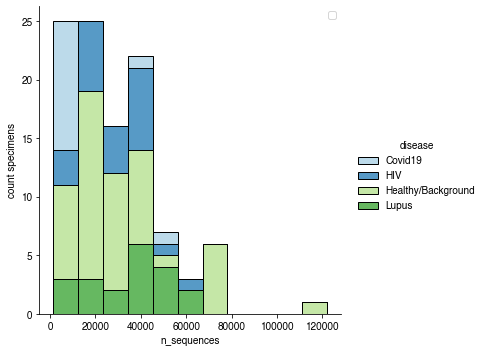

<Figure size 432x288 with 0 Axes>

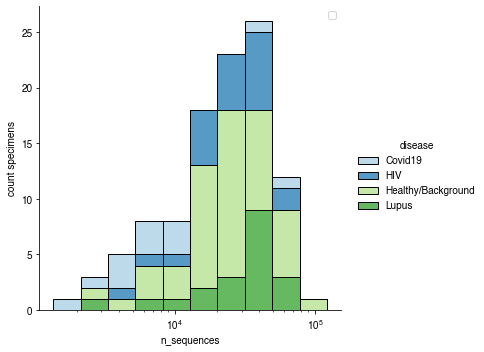

In [5]:
specimen_disease = (
    validation_embeddings.obs[["specimen_label", "disease"]]
    .drop_duplicates()
    .set_index("specimen_label")
)
specimen_disease["n_sequences"] = validation_embeddings.obs[
    "specimen_label"
].value_counts()

plt.figure()
sns.displot(
    x="n_sequences",
    hue="disease",
    multiple="stack",
    data=specimen_disease,
    palette="Paired",
)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("count specimens")

plt.figure()
sns.displot(
    x="n_sequences",
    hue="disease",
    multiple="stack",
    data=specimen_disease,
    palette="Paired",
    log_scale=True,
)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("count specimens")

## Plot raw sequence probabilities

Sequence model predicted class probabilities are enriched for sequences from individuals of each disease class. Sequences predicted to have higher disease association are enriched for sequences truly from patients with that disease. The healthy class exhibits a different pattern: sequences with higher “healthy or background” probability (higher x-value) may be healthy sequences within the immune repertoires of disease patients.

In [6]:
validation_seq_preds = pd.DataFrame(
    rollup_clf.clf_sequence_disease.predict_proba(
        rollup_clf.clf_sequence_disease.featurize(validation_embeddings).X,
    ),
    index=validation_embeddings.obs.specimen_label,
    columns=rollup_clf.clf_sequence_disease.classes_,
)

validation_seq_preds["true_label"] = (
    validation_embeddings.obs[["specimen_label", "disease"]]
    .drop_duplicates()
    .set_index("specimen_label")["disease"]
)

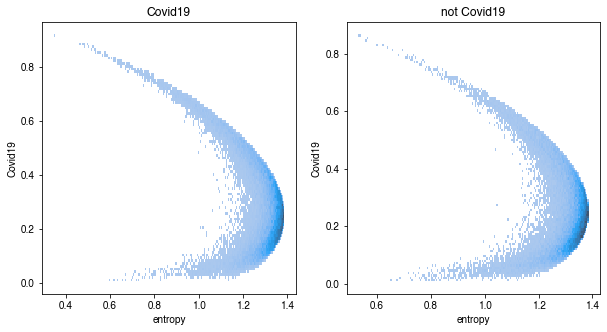

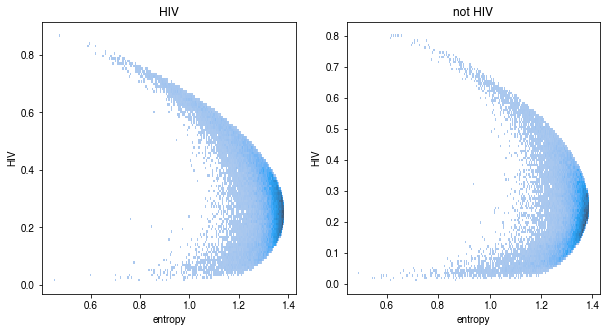

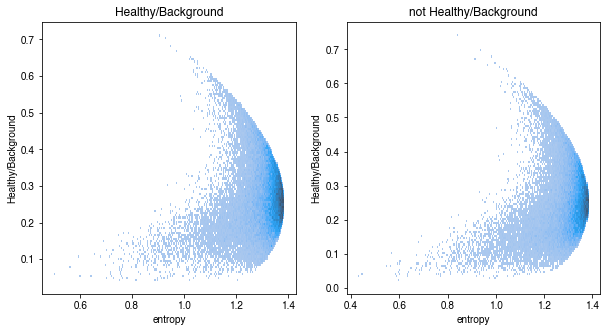

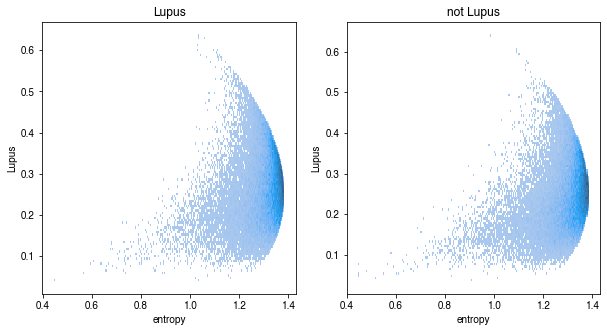

In [7]:
n = 50000
classes = rollup_clf.clf_sequence_disease.classes_
for i in classes:
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # sample n probabilities per disease
    subset = (
        validation_seq_preds.loc[validation_seq_preds.true_label == i]
        .sample(n)
        .reset_index()
    )
    subset["entropy"] = subset[classes].apply(
        lambda row: scipy.stats.entropy(row), axis=1
    )
    sns.histplot(x="entropy", y=i, data=subset, ax=ax[0])

    subset = (
        validation_seq_preds.loc[validation_seq_preds.true_label != i]
        .sample(n)
        .reset_index()
    )
    subset["entropy"] = subset[classes].apply(
        lambda row: scipy.stats.entropy(row), axis=1
    )
    sns.histplot(x="entropy", y=i, data=subset, ax=ax[1])
    ax[0].set_title(f"{i}")
    ax[1].set_title(f"not {i}")

['Covid19', 'HIV', 'Healthy/Background', 'Lupus']


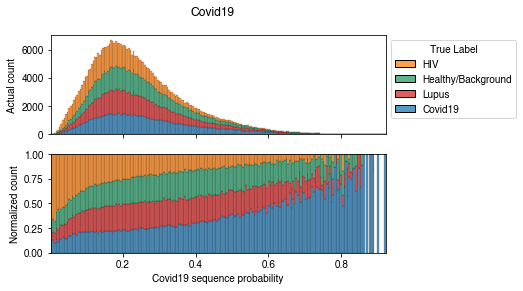

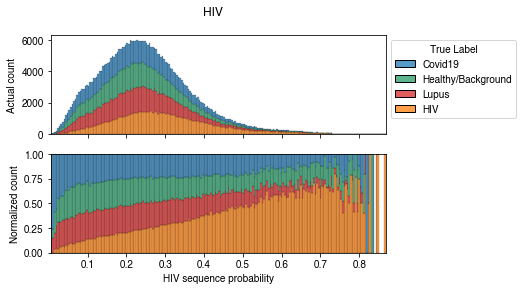

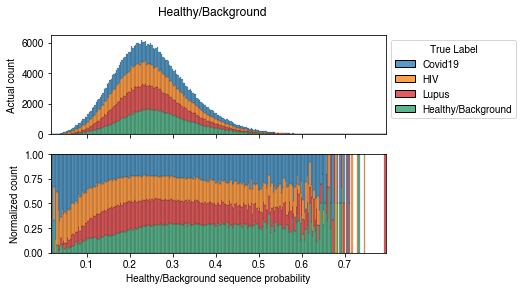

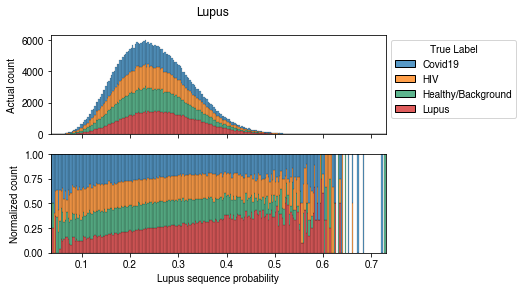

In [8]:
# weighted sample of sequence level predictions
data = (
    validation_seq_preds.groupby("true_label", observed=True)
    .apply(lambda df: df.sample(100000))
    .reset_index(drop=True)
)
classes = list(rollup_clf.clf_sequence_disease.classes_)
print(classes)


for col in classes:
    fig, ax = plt.subplots(2, 1, sharex=True)

    hue_order = classes.copy()
    hue_order.remove(col)
    hue_order = hue_order + [col]

    sns.histplot(
        x=col,
        hue="true_label",
        data=data,
        multiple="stack",
        ax=ax[0],
        palette=helpers.disease_color_palette,
        hue_order=hue_order,
    )
    sns.histplot(
        x=col,
        hue="true_label",
        data=data,
        multiple="fill",
        ax=ax[1],
        legend=False,
        palette=helpers.disease_color_palette,
        hue_order=hue_order,
    )
    ax[0].get_legend().set_title("True Label")
    sns.move_legend(ax[0], "upper left", bbox_to_anchor=(1, 1))
    fig.suptitle(f"{col}")
    ax[1].set_xlabel(f"{col} sequence probability")
    ax[0].set_ylabel("Actual count")
    ax[1].set_ylabel("Normalized count")
    genetools.plots.savefig(
        fig,
        config.paths.output_dir
        / f"sequence_aggregation_probabilties.{slugify(col)}.png",
        dpi=300,
    )

In [9]:
# to do :
# plot this for TCRs too
# make a true multi-panel figure

# Compare rollup strategies (on validation sets from different folds and loci)

In [10]:
# to do:
# - try inverse-weighted entropy for sequence level prediction

In [11]:
experiment_summary = []

for gene_locus in config.gene_loci_used:
    print(gene_locus)
    for fold_id in config.cross_validation_fold_ids:
        validation_embeddings = load_val_embeddings(fold_id, gene_locus)
        rollup_clf = build_classifier(fold_id, gene_locus)

        # run weighted_median strategy (no threshold required)
        experiment_summary.append(
            evaluate(
                rollup_clf=rollup_clf,
                proportiontocut=0,
                validation_embeddings=validation_embeddings,
                strategy="weighted_median",
                fold_id=fold_id,
                gene_locus=gene_locus,
            )
        )

        # run trimmed mean and trim bottom only strategies:
        # loop over possible thresholds for cutting
        for proportiontocut in [0, 0.025, 0.05, 0.1]:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                # run trimmed_mean rollup strategy
                experiment_summary.append(
                    evaluate(
                        rollup_clf=rollup_clf,
                        proportiontocut=proportiontocut,
                        validation_embeddings=validation_embeddings,
                        strategy="trimmed_mean",
                        fold_id=fold_id,
                        gene_locus=gene_locus,
                    )
                )
                # run trim_bottom_only rollup strategy
                experiment_summary.append(
                    evaluate(
                        rollup_clf=rollup_clf,
                        proportiontocut=proportiontocut,
                        validation_embeddings=validation_embeddings,
                        strategy="trim_bottom_only",
                        fold_id=fold_id,
                        gene_locus=gene_locus,
                    )
                )
        # run entropy threshold strategy, loop over different entropy thresholds

        # Above a certain entropy, the entropy threshold applies no filtering, acting as an untrimmed mean
        # That maximum entropy threshold is the entropy of the n-dim vector of all [1/n] entries
        n_classes = len(rollup_clf.classes_)
        maximum_entropy_cutoff = scipy.stats.entropy(np.ones(n_classes) / n_classes)

        for entropy_threshold in [1.6, 1.5, 1.4, 1.3, 1.2]:
            if entropy_threshold >= maximum_entropy_cutoff:
                # Skip if above the maximum entropy threshold
                continue

            experiment_summary.append(
                evaluate(
                    rollup_clf=rollup_clf,
                    proportiontocut=entropy_threshold,
                    validation_embeddings=validation_embeddings,
                    strategy="entropy_threshold",
                    fold_id=fold_id,
                    gene_locus=gene_locus,
                )
            )

2023-01-01 04:31:42,210 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.0.validation.h5ad -> /srv/scratch/maximz/cache/1a7cd102c4a71eb472da3636203a91984ec407adbc0812ffba2c07c5.0.validation.h5ad


GeneLocus.BCR
Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


2023-01-01 04:32:59,738 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.0.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 0
strategy: weighted_median
fold_id: 0
roc_auc: 0.8630249745158002
                    precision    recall  f1-score   support

           Covid19       1.00      0.60      0.75        15
               HIV       0.54      0.95      0.69        21
Healthy/Background       0.66      0.73      0.69        48
             Lupus       0.80      0.32      0.46        25

          accuracy                           0.66       109
         macro avg       0.75      0.65      0.65       109
      weighted avg       0.72      0.66      0.65       109

********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 0
strategy: trimmed_mean
fold_id: 0
roc_auc: 0.8711267656909859
                    precision    recall  f1-score   support

           Covid19       0.83      0.67      0.74        15
               HI

2023-01-01 04:44:22,349 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 04:44:22,364 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 04:44:22,368 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 1.3
strategy: entropy_threshold
fold_id: 0
roc_auc: 0.8655956021552352
                    precision    recall  f1-score   support

           Covid19       0.54      0.87      0.67        15
               HIV       0.43      1.00      0.60        21
Healthy/Background       0.78      0.58      0.67        48
             Lupus       0.00      0.00      0.00        25

          accuracy                           0.57       109
         macro avg       0.44      0.61      0.48       109
      weighted avg       0.50      0.57      0.50       109



2023-01-01 04:46:11,172 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 04:46:11,188 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 04:46:11,191 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 1.2
strategy: entropy_threshold
fold_id: 0
roc_auc: 0.8398121450415029
                    precision    recall  f1-score   support

           Covid19       0.33      1.00      0.49        15
               HIV       0.35      1.00      0.52        21
Healthy/Background       1.00      0.06      0.12        48
             Lupus       0.00      0.00      0.00        25

          accuracy                           0.36       109
         macro avg       0.42      0.52      0.28       109
      weighted avg       0.55      0.36      0.22       109



2023-01-01 04:46:22,596 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 0
strategy: weighted_median
fold_id: 1
roc_auc: 0.843941280941281
                    precision    recall  f1-score   support

           Covid19       1.00      0.38      0.56        13
               HIV       0.58      0.86      0.69        22
Healthy/Background       0.70      0.78      0.74        50
             Lupus       0.82      0.45      0.58        20

          accuracy                           0.69       105
         macro avg       0.77      0.62      0.64       105
      weighted avg       0.73      0.69      0.67       105

********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 0
strategy: trimmed_mean
fold_id: 1
roc_auc: 0.8489040959040958
                    precision    recall  f1-score   support

           Covid19       1.00      0.46      0.63        13
               HIV

2023-01-01 04:58:34,339 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 04:58:34,355 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 04:58:34,357 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 1.2
strategy: entropy_threshold
fold_id: 1
roc_auc: 0.8133830613830614
                    precision    recall  f1-score   support

           Covid19       0.19      0.77      0.31        13
               HIV       0.43      0.91      0.59        22
Healthy/Background       0.71      0.10      0.18        50
             Lupus       0.00      0.00      0.00        20

          accuracy                           0.33       105
         macro avg       0.34      0.44      0.27       105
      weighted avg       0.46      0.33      0.24       105

Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


2023-01-01 04:58:57,485 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.validation.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 0
strategy: weighted_median
fold_id: 2
roc_auc: 0.8588217230782753
                    precision    recall  f1-score   support

           Covid19       0.88      0.50      0.64        14
               HIV       0.51      0.86      0.64        21
Healthy/Background       0.76      0.75      0.75        51
             Lupus       0.69      0.48      0.56        23

          accuracy                           0.68       109
         macro avg       0.71      0.65      0.65       109
      weighted avg       0.71      0.68      0.68       109

********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 0
strategy: trimmed_mean
fold_id: 2
roc_auc: 0.864516329068524
                    precision    recall  f1-score   support

           Covid19       0.89      0.57      0.70        14
               HIV

2023-01-01 05:12:44,208 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.0.validation.h5ad -> /srv/scratch/maximz/cache/45c3001c6b505500991147d20f972274565d8728487b87ce1a92bfe9.0.validation.h5ad


********************************************************************************
gene_locus: GeneLocus.BCR
proportiontocut: 1.2
strategy: entropy_threshold
fold_id: 2
roc_auc: 0.8540083098789308
                    precision    recall  f1-score   support

           Covid19       0.43      0.93      0.59        14
               HIV       0.41      0.95      0.57        21
Healthy/Background       0.81      0.41      0.55        51
             Lupus       1.00      0.17      0.30        23

          accuracy                           0.53       109
         macro avg       0.66      0.62      0.50       109
      weighted avg       0.72      0.53      0.50       109

GeneLocus.TCR
Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


2023-01-01 05:14:01,240 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.0.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 0
strategy: weighted_median
fold_id: 0
roc_auc: 0.8961662184253547
                    precision    recall  f1-score   support

           Covid19       0.50      0.77      0.61        13
               HIV       0.51      0.95      0.67        21
Healthy/Background       0.95      0.49      0.65        43
             Lupus       0.80      0.57      0.67        14

          accuracy                           0.65        91
         macro avg       0.69      0.70      0.65        91
      weighted avg       0.76      0.65      0.65        91

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 0
strategy: trimmed_mean
fold_id: 0
roc_auc: 0.8981200388049353
                    precision    recall  f1-score   support

           Covid19       0.57      0.62      0.59        13
               HI

2023-01-01 05:27:17,631 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 05:27:17,647 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 05:27:17,650 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 1.3
strategy: entropy_threshold
fold_id: 0
roc_auc: 0.7872222830694592
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        13
               HIV       0.63      0.90      0.75        21
Healthy/Background       0.00      0.00      0.00        43
             Lupus       0.23      1.00      0.37        14

          accuracy                           0.36        91
         macro avg       0.22      0.48      0.28        91
      weighted avg       0.18      0.36      0.23        91



2023-01-01 05:29:25,208 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 05:29:25,224 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 05:29:25,226 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 1.2
strategy: entropy_threshold
fold_id: 0
roc_auc: 0.6530137948487041
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        13
               HIV       0.50      0.10      0.16        21
Healthy/Background       0.00      0.00      0.00        43
             Lupus       0.16      1.00      0.28        14

          accuracy                           0.18        91
         macro avg       0.17      0.27      0.11        91
      weighted avg       0.14      0.18      0.08        91

Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


2023-01-01 05:30:27,740 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.1.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 0
strategy: weighted_median
fold_id: 1
roc_auc: 0.8640429338103757
                    precision    recall  f1-score   support

           Covid19       0.64      0.58      0.61        12
               HIV       0.64      0.95      0.76        22
Healthy/Background       0.91      0.67      0.77        43
             Lupus       0.73      0.79      0.76        14

          accuracy                           0.75        91
         macro avg       0.73      0.75      0.73        91
      weighted avg       0.78      0.75      0.75        91

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 0
strategy: trimmed_mean
fold_id: 1
roc_auc: 0.8643226467146733
                    precision    recall  f1-score   support

           Covid19       0.83      0.42      0.56        12
               HI

2023-01-01 05:46:50,923 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 05:46:50,943 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 05:46:50,946 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 1.2
strategy: entropy_threshold
fold_id: 1
roc_auc: 0.7435492709579088
                    precision    recall  f1-score   support

           Covid19       0.50      0.08      0.14        12
               HIV       0.62      0.68      0.65        22
Healthy/Background       0.00      0.00      0.00        43
             Lupus       0.22      1.00      0.35        14

          accuracy                           0.33        91
         macro avg       0.34      0.44      0.29        91
      weighted avg       0.25      0.33      0.23        91

Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


2023-01-01 05:47:47,340 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.2.validation.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 0
strategy: weighted_median
fold_id: 2
roc_auc: 0.8936919059201668
                    precision    recall  f1-score   support

           Covid19       0.59      0.77      0.67        13
               HIV       0.57      0.95      0.71        21
Healthy/Background       1.00      0.55      0.71        44
             Lupus       0.69      0.79      0.73        14

          accuracy                           0.71        92
         macro avg       0.71      0.76      0.71        92
      weighted avg       0.80      0.71      0.71        92

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 0
strategy: trimmed_mean
fold_id: 2
roc_auc: 0.8857860135034049
                    precision    recall  f1-score   support

           Covid19       0.71      0.77      0.74        13
               HI

2023-01-01 06:01:10,040 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 06:01:10,057 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 06:01:10,060 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 1.3
strategy: entropy_threshold
fold_id: 2
roc_auc: 0.7695536649340998
                    precision    recall  f1-score   support

           Covid19       1.00      0.08      0.14        13
               HIV       0.52      0.52      0.52        21
Healthy/Background       0.00      0.00      0.00        44
             Lupus       0.20      1.00      0.33        14

          accuracy                           0.28        92
         macro avg       0.43      0.40      0.25        92
      weighted avg       0.29      0.28      0.19        92



2023-01-01 06:03:16,924 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 06:03:16,940 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

2023-01-01 06:03:16,943 - py.warnings - WARNING - /users/maximz/anaconda3/envs/cuda-env-py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are 

********************************************************************************
gene_locus: GeneLocus.TCR
proportiontocut: 1.2
strategy: entropy_threshold
fold_id: 2
roc_auc: 0.6227291730009121
                    precision    recall  f1-score   support

           Covid19       0.00      0.00      0.00        13
               HIV       0.46      0.29      0.35        21
Healthy/Background       0.00      0.00      0.00        44
             Lupus       0.16      0.93      0.28        14

          accuracy                           0.21        92
         macro avg       0.16      0.30      0.16        92
      weighted avg       0.13      0.21      0.12        92



In [12]:
summary_df = (
    pd.concat(experiment_summary, axis=1)
    .T.sort_values("roc_auc", ascending=False)
    .reset_index(drop=True)
)
summary_df.to_csv(
    config.paths.output_dir / "sequence_classifier_rollup_strategy_comparisons.tsv",
    sep="\t",
    index=None,
)
summary_df

,Covid19_precision,HIV_precision,Healthy/Background_precision,Lupus_precision,Covid19_recall,HIV_recall,Healthy/Background_recall,Lupus_recall,roc_auc,proportiontocut,strategy,fold_id,gene_locus
0,0.625,0.540541,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.901108,0.1,trimmed_mean,0,TCR
1,0.714286,0.477273,1.0,0.785714,0.384615,1.0,0.604651,0.785714,0.900588,0.1,trim_bottom_only,0,TCR
2,0.588235,0.555556,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.900271,0.05,trimmed_mean,0,TCR
3,0.75,0.488372,1.0,0.785714,0.461538,1.0,0.604651,0.785714,0.899276,0.05,trim_bottom_only,0,TCR
4,0.625,0.571429,0.964286,0.833333,0.769231,0.952381,0.627907,0.714286,0.899016,0.025,trimmed_mean,0,TCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.0,0.633333,0.0,0.229508,0.0,0.904762,0.0,1.0,0.787222,1.3,entropy_threshold,0,TCR
62,1.0,0.52381,0.0,0.2,0.076923,0.52381,0.0,1.0,0.769554,1.3,entropy_threshold,2,TCR
63,0.5,0.625,0.0,0.215385,0.083333,0.681818,0.0,1.0,0.743549,1.2,entropy_threshold,1,TCR
64,0.0,0.5,0.0,0.16092,0.0,0.095238,0.0,1.0,0.653014,1.2,entropy_threshold,0,TCR


In [2]:
# Reload from disk - can restart here
summary_df = pd.read_csv(
    config.paths.output_dir / "sequence_classifier_rollup_strategy_comparisons.tsv",
    sep="\t",
)
summary_df

,Covid19_precision,HIV_precision,Healthy/Background_precision,Lupus_precision,Covid19_recall,HIV_recall,Healthy/Background_recall,Lupus_recall,roc_auc,proportiontocut,strategy,fold_id,gene_locus
0,0.625000,0.540541,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.901108,0.100,trimmed_mean,0,TCR
1,0.714286,0.477273,1.000000,0.785714,0.384615,1.000000,0.604651,0.785714,0.900588,0.100,trim_bottom_only,0,TCR
2,0.588235,0.555556,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.900271,0.050,trimmed_mean,0,TCR
3,0.750000,0.488372,1.000000,0.785714,0.461538,1.000000,0.604651,0.785714,0.899276,0.050,trim_bottom_only,0,TCR
4,0.625000,0.571429,0.964286,0.833333,0.769231,0.952381,0.627907,0.714286,0.899016,0.025,trimmed_mean,0,TCR
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.000000,0.633333,0.000000,0.229508,0.000000,0.904762,0.000000,1.000000,0.787222,1.300,entropy_threshold,0,TCR
62,1.000000,0.523810,0.000000,0.200000,0.076923,0.523810,0.000000,1.000000,0.769554,1.300,entropy_threshold,2,TCR
63,0.500000,0.625000,0.000000,0.215385,0.083333,0.681818,0.000000,1.000000,0.743549,1.200,entropy_threshold,1,TCR
64,0.000000,0.500000,0.000000,0.160920,0.000000,0.095238,0.000000,1.000000,0.653014,1.200,entropy_threshold,0,TCR


In [3]:
# Rename for clarity: 0% trimming should be called "untrimmed mean"
summary_df.loc[
    summary_df["strategy"].isin(["trim_bottom_only", "trimmed_mean"])
    & (summary_df["proportiontocut"] == 0),
    "strategy",
] = "untrimmed_mean"

In [4]:
# sns.boxplot(x='strategy',y='roc_auc', hue='proportiontocut', data=summary_df.loc[summary_df.strategy.isin(['entropy_threshold'])
# plt.legend(bbox_to_anchor=(1,1))
# plt.xticks(rotation=45, ha='right')

In [5]:
# to do: show proportiontocut range included in each strategy
summary_df_agg = (
    summary_df.groupby(["gene_locus", "strategy"], observed=True)
    .agg({"roc_auc": ["min", "mean", "max", "var"]})
    .round(3)
)
summary_df_agg.to_csv(
    config.paths.output_dir
    / "sequence_classifier_rollup_strategy_comparisons.aggregated.tsv",
    sep="\t",
)
summary_df_agg

roc_auc                     
                                 min   mean    max    var
gene_locus strategy                                      
BCR        entropy_threshold   0.813  0.846  0.866  0.000
           trim_bottom_only    0.843  0.858  0.871  0.000
           trimmed_mean        0.817  0.842  0.862  0.000
           untrimmed_mean      0.849  0.862  0.871  0.000
           weighted_median     0.844  0.855  0.863  0.000
TCR        entropy_threshold   0.623  0.731  0.809  0.006
           trim_bottom_only    0.866  0.885  0.901  0.000
           trimmed_mean        0.866  0.885  0.901  0.000
           untrimmed_mean      0.864  0.883  0.898  0.000
           weighted_median     0.864  0.885  0.896  0.000

In [19]:
summary_df_agg_simpler = (
    summary_df.groupby(["strategy", "gene_locus"], observed=True)["roc_auc"]
    .agg(["mean", "std"])
    .apply(lambda row: f"{row['mean']:0.3f} +/- {row['std']:0.3f}", axis=1)
    .unstack()
    .sort_values(["TCR", "BCR"], ascending=False)
)
summary_df_agg_simpler.to_csv(
    config.paths.output_dir
    / "sequence_classifier_rollup_strategy_comparisons.aggregated_simpler.tsv",
    sep="\t",
)
summary_df_agg_simpler

gene_locus,BCR,TCR
strategy,,
weighted_median,0.855 +/- 0.010,0.885 +/- 0.018
trimmed_mean,0.842 +/- 0.015,0.885 +/- 0.015
trim_bottom_only,0.858 +/- 0.010,0.885 +/- 0.014
untrimmed_mean,0.862 +/- 0.010,0.883 +/- 0.015
entropy_threshold,0.846 +/- 0.019,0.731 +/- 0.076


In [16]:
# what's in each strategy?
summary_df.groupby("strategy")["proportiontocut"].unique()

strategy
entropy_threshold            [1.3, 1.2]
trim_bottom_only     [0.1, 0.05, 0.025]
trimmed_mean         [0.1, 0.05, 0.025]
untrimmed_mean                    [0.0]
weighted_median                   [0.0]
Name: proportiontocut, dtype: object

<Figure size 720x720 with 0 Axes>

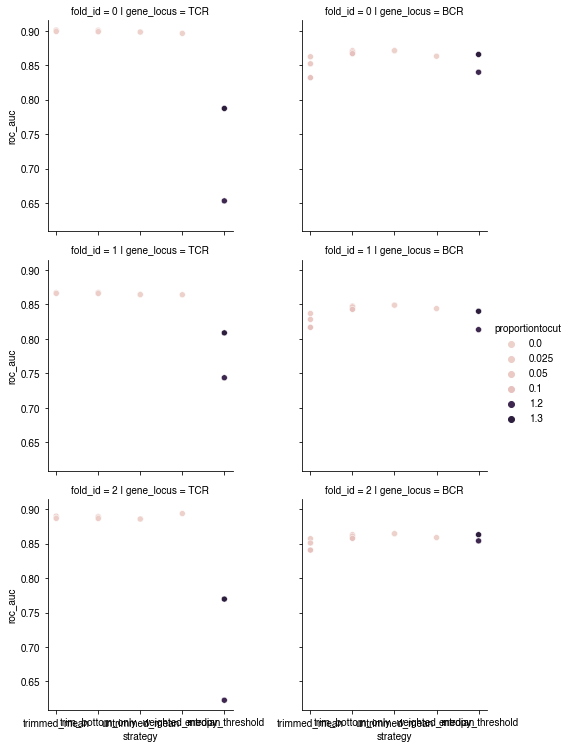

In [6]:
plt.figure(figsize=(10, 10))
g = sns.FacetGrid(summary_df, col="gene_locus", row="fold_id", height=3.5)
g.map_dataframe(sns.scatterplot, x="strategy", y="roc_auc", hue="proportiontocut")
g.add_legend(title="proportiontocut")

In [7]:
# TODO: just use summary_df.loc[summary_df.groupby(["gene_locus", "strategy"], observed=True)["roc_auc"].idxmax()] ?
idx = (
    summary_df.groupby(["gene_locus", "strategy"], observed=True)["roc_auc"].transform(
        max
    )
    == summary_df["roc_auc"]
)
summary_df.loc[idx]

,Covid19_precision,HIV_precision,Healthy/Background_precision,Lupus_precision,Covid19_recall,HIV_recall,Healthy/Background_recall,Lupus_recall,roc_auc,proportiontocut,strategy,fold_id,gene_locus
0,0.625000,0.540541,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.901108,0.100,trimmed_mean,0,TCR
1,0.714286,0.477273,1.000000,0.785714,0.384615,1.000000,0.604651,0.785714,0.900588,0.100,trim_bottom_only,0,TCR
6,0.571429,0.571429,1.000000,0.733333,0.615385,0.952381,0.627907,0.785714,0.898120,0.000,untrimmed_mean,0,TCR
7,0.571429,0.571429,1.000000,0.733333,0.615385,0.952381,0.627907,0.785714,0.898120,0.000,untrimmed_mean,0,TCR
8,0.500000,0.512821,0.954545,0.800000,0.769231,0.952381,0.488372,0.571429,0.896166,0.000,weighted_median,0,TCR
18,0.833333,0.465116,0.687500,0.666667,0.666667,0.952381,0.687500,0.160000,0.871127,0.000,untrimmed_mean,0,BCR
19,0.833333,0.465116,0.687500,0.666667,0.666667,0.952381,0.687500,0.160000,0.871127,0.000,untrimmed_mean,0,BCR
20,0.833333,0.465116,0.687500,0.666667,0.666667,0.952381,0.687500,0.160000,0.871083,0.025,trim_bottom_only,0,BCR
29,0.541667,0.428571,0.777778,0.000000,0.866667,1.000000,0.583333,0.000000,0.865596,1.300,entropy_threshold,0,BCR
35,1.000000,0.540541,0.660377,0.800000,0.600000,0.952381,0.729167,0.320000,0.863025,0.000,weighted_median,0,BCR


In [8]:
summary_df.groupby(["gene_locus", "strategy", "proportiontocut"], observed=True).agg(
    {"roc_auc": ["mean", "var", "min", "max"]}
)

roc_auc                      \
                                                  mean       var       min   
gene_locus strategy          proportiontocut                                 
BCR        entropy_threshold 1.200            0.835735  0.000425  0.813383   
                             1.300            0.856228  0.000197  0.840095   
           trim_bottom_only  0.025            0.860591  0.000142  0.847666   
                             0.050            0.858905  0.000133  0.846472   
                             0.100            0.855819  0.000146  0.842913   
           trimmed_mean      0.025            0.852103  0.000181  0.836846   
                             0.050            0.843762  0.000181  0.828250   
                             0.100            0.829764  0.000146  0.816739   
           untrimmed_mean    0.000            0.861516  0.000104  0.848904   
           weighted_median   0.000            0.855263  0.000101  0.843941   
TCR        entropy_threshold 1.200            0.673097  0.003952  0.622729   
                             1.300            0.788494  0.000384  0.769554   
           trim_bottom_only  0.025            0.883742  0.000275  0.865935   
                             0.050            0.884979  0.000264  0.867330   
                             0.100            0.885543  0.000296  0.866766   
           trimmed_mean      0.025            0.883935  0.000277  0.866084   
                             0.050            0.884986  0.000282  0.866997   
                             0.100            0.885737  0.000314  0.866364   
           untrimmed_mean    0.000            0.882743  0.000234  0.864323   
           weighted_median   0.000            0.884634  0.000320  0.864043   

                                                        
                                                   max  
gene_locus strategy          proportiontocut            
BCR        entropy_threshold 1.200            0.854008  
                             1.300            0.865596  
           trim_bottom_only  0.025            0.871083  
                             0.050            0.869199  
                             0.100            0.866824  
           trimmed_mean      0.025            0.862258  
                             0.050            0.852029  
                             0.100            0.840661  
           untrimmed_mean    0.000            0.871127  
           weighted_median   0.000            0.863025  
TCR        entropy_threshold 1.200            0.743549  
                             1.300            0.808705  
           trim_bottom_only  0.025            0.898711  
                             0.050            0.899276  
                             0.100            0.900588  
           trimmed_mean      0.025            0.899016  
                             0.050            0.900271  
                             0.100            0.901108  
           untrimmed_mean    0.000            0.898120  
           weighted_median   0.000            0.896166

In [9]:
pd.set_option("display.max_rows", 300)
summary_df.sort_values("roc_auc", ascending=False)

,Covid19_precision,HIV_precision,Healthy/Background_precision,Lupus_precision,Covid19_recall,HIV_recall,Healthy/Background_recall,Lupus_recall,roc_auc,proportiontocut,strategy,fold_id,gene_locus
0,0.625000,0.540541,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.901108,0.100,trimmed_mean,0,TCR
1,0.714286,0.477273,1.000000,0.785714,0.384615,1.000000,0.604651,0.785714,0.900588,0.100,trim_bottom_only,0,TCR
2,0.588235,0.555556,0.962963,0.818182,0.769231,0.952381,0.604651,0.642857,0.900271,0.050,trimmed_mean,0,TCR
3,0.750000,0.488372,1.000000,0.785714,0.461538,1.000000,0.604651,0.785714,0.899276,0.050,trim_bottom_only,0,TCR
4,0.625000,0.571429,0.964286,0.833333,0.769231,0.952381,0.627907,0.714286,0.899016,0.025,trimmed_mean,0,TCR
5,0.666667,0.526316,1.000000,0.733333,0.615385,0.952381,0.604651,0.785714,0.898711,0.025,trim_bottom_only,0,TCR
6,0.571429,0.571429,1.000000,0.733333,0.615385,0.952381,0.627907,0.785714,0.898120,0.000,untrimmed_mean,0,TCR
7,0.571429,0.571429,1.000000,0.733333,0.615385,0.952381,0.627907,0.785714,0.898120,0.000,untrimmed_mean,0,TCR
8,0.500000,0.512821,0.954545,0.800000,0.769231,0.952381,0.488372,0.571429,0.896166,0.000,weighted_median,0,TCR
9,0.588235,0.571429,1.000000,0.687500,0.769231,0.952381,0.545455,0.785714,0.893692,0.000,weighted_median,2,TCR
